In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics as stat
from photoz_metrics import *

In [37]:
def calculate_biweight_bias(z_photo,z_spec,M):

# The biweight bias defined in HSC PDR2 paper. M stand for the median of z_photo. And this function can be
# iteratively applyed by replacing M with previous output of this function. We need to iterate this function
#till the incremental difference in the ouput reaches 0.1%.

    delz = (z_photo - z_spec)/(1+z_spec)
    z_mad = stat.median(abs(delz-M))
    u = (delz - M)/(6*z_mad)
    a = 0
    b = 0
    for i in range(len(u)):
        if abs(u[i]) < 1.0:
            a += (delz[i]-M)*(1-u[i]**2)**2
            b += (1-u[i]**2)**2
    
    bias_bw = M + a/b
    return bias_bw           

In [38]:
def calculate_biweight_scatter(z_photo,z_spec,M):

# The biweight scatter is also defined in HSC PDR2 paper, measuring how much the photo-z is scattered around 
# the true spec-z value. We simultaneously iterate the function with biweight bias by replacing M with b_bw.
    
    delz = (z_photo - z_spec)/(1+z_spec)
    z_mad = stat.median(abs(delz-M))
    u = (delz - M)/(9*z_mad)
    a = 0
    b = 0
    for i in range(len(u)):
        if abs(u[i]) < 1:
            a += ((delz[i]-M)**2)*(1-u[i]**2)**4
            b += (1-u[i]**2)*(1-5*u[i]**2)
    
    scatter_biweight = stat.sqrt(len(z_photo)*a)/abs(b)
    return scatter_biweight
    

In [39]:
def calculate_conv_outlier_rate(z_photo,z_spec):

# This function calculate the conventional outlier rate. 

    delz = (z_photo - z_spec)/(1+z_spec)
    number_outlier = len(np.where(abs(delz)>0.15)[0])
    outlier_rate_conv = number_outlier/len(z_photo)
    return outlier_rate_conv

In [40]:
def calculate_biweight_outlier_rate(z_photo,z_spec,b_bw,sigma_bw):
    
# The biweight outlier rate defined in HSC DPR2 paper. 

    delz = (z_photo - z_spec)/(1+z_spec)
    number_outlier = len(np.where(abs(delz-b_bw)>2*sigma_bw)[0])
    outlier_rate_conv = number_outlier/len(z_photo)
    return outlier_rate_conv
    
    

In [41]:
def calculate_loss_function(z_photo, z_spec):
    
# The loss function defined in HSC paper. 
    
    delz = (z_photo - z_spec)/(1+z_spec)
    L = 1-(1/(1+(delz/0.15)**2))
    
    return L

In [67]:
ls

forced_forced2_spec_z_matched_online.csv
matched_photozdata_with_spectrozdata_full_unfiltered.csv
matched_photozdata_with_spectrozdata_full_unfiltered_readable.csv
spectroscopic_data_only.fits
trimmed_forced_forced2_spec_z_matched_online.csv


In [46]:
data_demp = pd.read_csv("demp_match4.csv")

In [47]:
data_demp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61203 entries, 0 to 61202
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   # object_id_1       61203 non-null  int64  
 1   photoz_mean         61203 non-null  float64
 2   photoz_best         61203 non-null  float64
 3   photoz_conf_mean    61203 non-null  float64
 4   photoz_conf_best    61203 non-null  float64
 5   # object_id_2       61203 non-null  int64  
 6   specz_redshift_err  61203 non-null  float64
 7   specz_redshift      61203 non-null  float64
 8   specz_mag_i         59170 non-null  float64
 9   specz_name          61203 non-null  object 
 10  specz_ra            61203 non-null  float64
 11  specz_dec           61203 non-null  float64
 12  ra                  61203 non-null  float64
 13  dec                 61203 non-null  float64
 14  coord               61203 non-null  object 
 15  skymap_id           61203 non-null  int64  
 16  g_cm

In [51]:
data_demp[["photoz_best","specz_redshift"]]


,photoz_best,specz_redshift
0,0.01,0.596520
1,0.45,0.523920
2,0.61,0.621390
3,1.07,0.004036
4,0.59,0.616630
...,...,...
61198,1.82,1.927340
61199,2.10,2.128180
61200,0.15,0.000770
61201,0.01,0.987160


In [48]:
specz = data_demp["specz_redshift"]
photoz_best = data_demp["photoz_best"]
photoz_mean = data_demp["photoz_mean"]
photoz_conf_best = data_demp["photoz_conf_best"]
photoz_conf_mean = data_demp["photoz_conf_mean"]
mag = data_demp["y_cmodel_mag"]

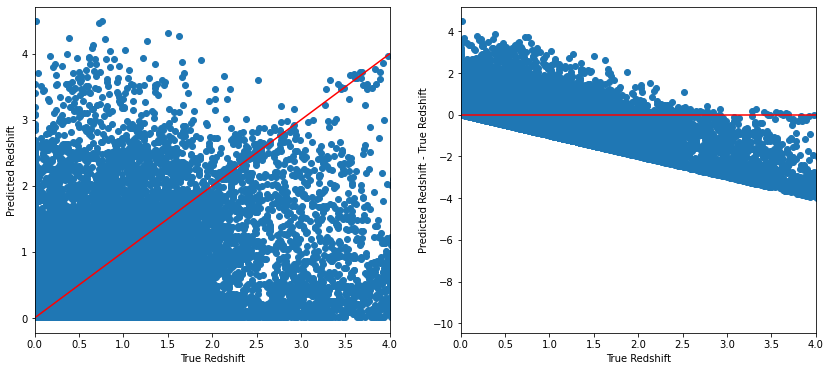

In [52]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(specz,photoz_best,'o')
plt.xlim(0,4)
plt.ylabel('Predicted Redshift')
plt.xlabel('True Redshift')
plt.plot([0,4], [0,4], color='red')
plt.subplot(1,2,2)
plt.plot(specz,photoz_best-specz,'o')
plt.xlim(0,4)
plt.ylabel('Predicted Redshift - True Redshift')
plt.xlabel('True Redshift')
plt.plot([0,4], [0,0], color='red')

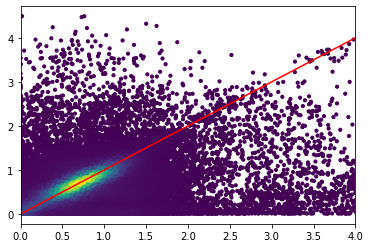

In [53]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([specz,photoz_best])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(specz, photoz_best, c=z, s=10)
plt.plot([0,4], [0,4], color='red')
plt.xlim(0,4)
plt.show()

In [59]:
delz = (photoz_best - specz)/(1+specz)
z_median = stat.median(delz)
b_bw = calculate_biweight_bias(photoz_best,specz,z_median)
sigma_bw = calculate_biweight_scatter(photoz_best,specz,z_median)
outlier_rate = calculate_biweight_outlier_rate(photoz_best,specz,b_bw,sigma_bw)
loss_function = calculate_loss_function(photoz_best,specz)
conv_outlier_rate = calculate_conv_outlier_rate(photoz_best,specz)

diff = z_median=b_bw

while diff > 0.001:
    b_bw_new = calculate_biweight_bias(photoz_best,specz,b_bw)
    sigma_bw = calculate_biweight_scatter(photoz_best,specz,b_bw_new)
    outlier_rate = calculate_biweight_outlier_rate(photoz_best,specz,b_bw_new,sigma_bw)
    conv_outlier_rate = calculate_conv_outlier_rate(photoz_best,specz)
    diff = b_bw -b_bw_new
    b_bw = b_bw_new

average_loss = sum(loss_function)/len(loss_function)


print (b_bw)
print(sigma_bw)
print(outlier_rate)
print(conv_outlier_rate)
print(average_loss)

-0.002928673920692774
0.06027641618740042
0.2803620737545545
0.2529287780010784
0.2604543412355538


In [123]:
print ("Zphot           bias     sigma_bw     outlier_rate_bw     conv_outlier_rate      <L(delz)>   # of galaxies")

x_list = []
biweight_bias = []
biweight_scatter = []
biweight_outlier = []
loss = []
conv_bias = []
conv_scatter = []
conv_outlier = []

for i in range(20):
    index = np.intersect1d(np.where(photoz_best>=0.2*i)[0],np.where(photoz_best<0.2*i+0.2)[0])
    photoz_best_filtered = np.asarray(photoz_best[index])
    specz_filtered= np.asarray(specz[index])
    x_list.append(0.2*i+0.1)
    
    delz_filtered = (photoz_best_filtered - specz_filtered)/(1+specz_filtered)
    z_median_filtered = stat.median(delz_filtered)
    
    b_bw = calculate_biweight_bias(photoz_best_filtered,specz_filtered,z_median_filtered)
    sigma_bw = calculate_biweight_scatter(photoz_best_filtered,specz_filtered,z_median_filtered)
    outlier_rate = calculate_biweight_outlier_rate(photoz_best_filtered,specz_filtered,b_bw,sigma_bw)
    loss_function = calculate_loss_function(photoz_best_filtered,specz_filtered)
    conv_outlier_rate = calculate_conv_outlier_rate(photoz_best_filtered,specz_filtered)
    average_loss = sum(loss_function)/len(loss_function)
    
    diff = z_median_filtered-b_bw

    while diff > 0.001:
        b_bw_new = calculate_biweight_bias(photoz_best_filtered,specz_filtered,b_bw)
        sigma_bw = calculate_biweight_scatter(photoz_best_filtered,specz_filtered,b_bw_new)
        outlier_rate = calculate_biweight_outlier_rate(photoz_best_filtered,specz_filtered,b_bw_new,sigma_bw)
        diff = b_bw -b_bw_new
        b_bw = b_bw_new
    
    biweight_bias.append(b_bw)
    biweight_scatter.append(sigma_bw)
    biweight_outlier.append(outlier_rate)
    loss.append(average_loss)
    conv_bias.append(calculate_bias(photoz_best_filtered,specz_filtered,False))
    conv_scatter.append(calculate_scatter(photoz_best_filtered,specz_filtered,False))
    conv_outlier.append(conv_outlier_rate)

    print ("%.2f - %.2f   %+f   %.3f            %.3f              %.3f              %.3f         %s"%(0.2*i,round(0.2*i+0.2,2),round(b_bw,3),round(sigma_bw,3),round(outlier_rate,3),round(conv_outlier_rate,3),round(average_loss,3),len(specz_filtered)))

Zphot           bias     sigma_bw     outlier_rate_bw     conv_outlier_rate      <L(delz)>   # of galaxies
0.00 - 0.20   -0.207000   0.305            0.024              0.480              0.460         6626
0.20 - 0.40   -0.042000   0.171            0.155              0.371              0.361         6019
0.40 - 0.60   -0.010000   0.063            0.236              0.213              0.227         10827
0.60 - 0.80   -0.000000   0.033            0.211              0.117              0.137         14935
0.80 - 1.00   -0.004000   0.038            0.213              0.134              0.155         12381
1.00 - 1.20   +0.001000   0.069            0.269              0.257              0.265         5054
1.20 - 1.40   +0.031000   0.225            0.191              0.420              0.422         1988
1.40 - 1.60   +0.100000   0.382            0.098              0.568              0.531         1009
1.60 - 1.80   +0.077000   0.383            0.115              0.561              0.534    

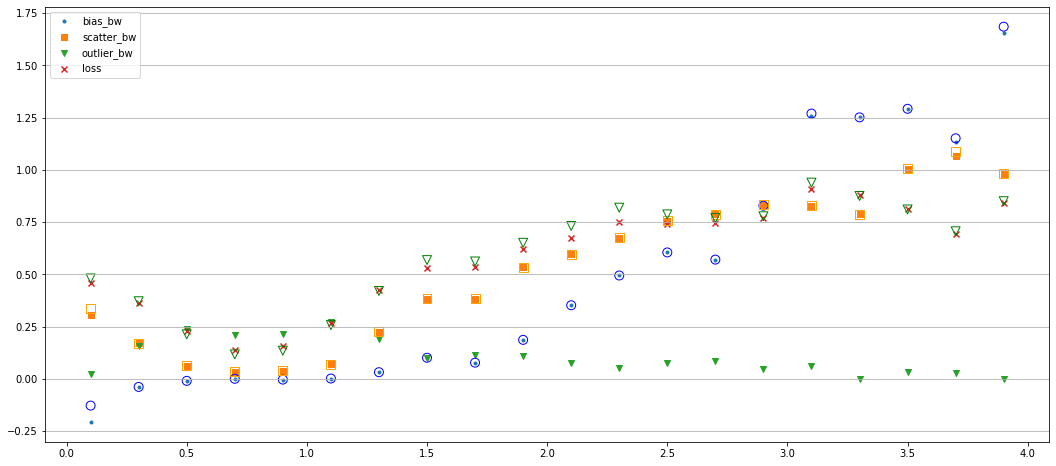

In [134]:
plt.scatter(x_list,biweight_bias,marker = ".",label = "bias_bw")
plt.scatter(x_list,biweight_scatter, marker = "s",label = "scatter_bw")
plt.scatter(x_list,biweight_outlier, marker = "v", label = "outlier_bw")
plt.scatter(x_list,loss, marker = "x", label = "loss")
plt.scatter(x_list,conv_bias,s=80, facecolors='none', edgecolors='b')
plt.scatter(x_list,conv_scatter,marker = "s",edgecolors = 'orange',facecolors = 'none',s = 80)
plt.scatter(x_list,conv_outlier,marker = "v",edgecolors = 'green',facecolors = 'none',s = 80)

plt.legend()
plt.rcParams["figure.figsize"] = (18,8)
plt.gca().yaxis.grid(True)
plt.show()

In [129]:
print ("mag           bias       sigma_bw     outlier_rate_bw  conv_outlier_rate   <L(delz)>")

x_list_mag = []
biweight_bias_mag = []
biweight_scatter_mag = []
biweight_outlier_mag = []
loss_mag = []
conv_bias_mag = []
conv_scatter_mag = []
conv_outlier_mag = []


for i in range(26):
    index = np.intersect1d(np.where(mag>=18.5+0.25*i)[0],np.where(mag<0.25*i+18.75)[0])
    photoz_best_filtered = np.asarray(photoz_best[index])
    specz_filtered= np.asarray(specz[index])
    x_list_mag.append(0.25*i+18.625)
    
    delz_filtered = (photoz_best_filtered - specz_filtered)/(1+specz_filtered)
    z_median_filtered = stat.median(delz_filtered)
    
    b_bw = calculate_biweight_bias(photoz_best_filtered,specz_filtered,z_median_filtered)
    sigma_bw = calculate_biweight_scatter(photoz_best_filtered,specz_filtered,z_median_filtered)
    outlier_rate = calculate_biweight_outlier_rate(photoz_best_filtered,specz_filtered,b_bw,sigma_bw)
    loss_function = calculate_loss_function(photoz_best_filtered,specz_filtered)
    conv_outlier_rate = calculate_conv_outlier_rate(photoz_best_filtered,specz_filtered)


    diff = z_median=b_bw

    while diff > 0.001:
        b_bw_new = calculate_biweight_bias(photoz_best_filtered,specz_filtered,b_bw)
        sigma_bw = calculate_biweight_scatter(photoz_best_filtered,specz_filtered,b_bw_new)
        outlier_rate = calculate_biweight_outlier_rate(photoz_best_filtered,specz_filtered,b_bw_new,sigma_bw)
        diff = b_bw -b_bw_new
        b_bw = b_bw_new

    average_loss = sum(loss_function)/len(loss_function)
    
    biweight_bias_mag.append(b_bw)
    biweight_scatter_mag.append(sigma_bw)
    biweight_outlier_mag.append(outlier_rate)
    loss_mag.append(average_loss)
    conv_bias_mag.append(calculate_bias(photoz_best_filtered,specz_filtered,False))
    conv_scatter_mag.append(calculate_scatter(photoz_best_filtered,specz_filtered,False))
    conv_outlier_mag.append(conv_outlier_rate)
    
    print ("%.2f - %.2f   %+f   %.3f            %.3f            %.3f           %.3f        %s"%(18.5+0.25*i,0.25*i+18.75,round(b_bw,3),round(sigma_bw,3),round(outlier_rate,3),round(conv_outlier_rate,3),round(average_loss,3),len(specz_filtered)))

mag           bias       sigma_bw     outlier_rate_bw  conv_outlier_rate   <L(delz)>
18.50 - 18.75   +0.005000   0.050            0.292            0.219           0.237        511
18.75 - 19.00   +0.004000   0.046            0.298            0.230           0.236        712
19.00 - 19.25   -0.000000   0.044            0.301            0.252           0.247        975
19.25 - 19.50   +0.000000   0.039            0.281            0.216           0.221        1156
19.50 - 19.75   -0.001000   0.048            0.279            0.229           0.236        1520
19.75 - 20.00   -0.002000   0.050            0.292            0.253           0.251        1813
20.00 - 20.25   -0.002000   0.044            0.278            0.216           0.227        2263
20.25 - 20.50   -0.002000   0.047            0.272            0.213           0.224        2785
20.50 - 20.75   -0.001000   0.048            0.277            0.215           0.223        3804
20.75 - 21.00   -0.001000   0.048            0.273    

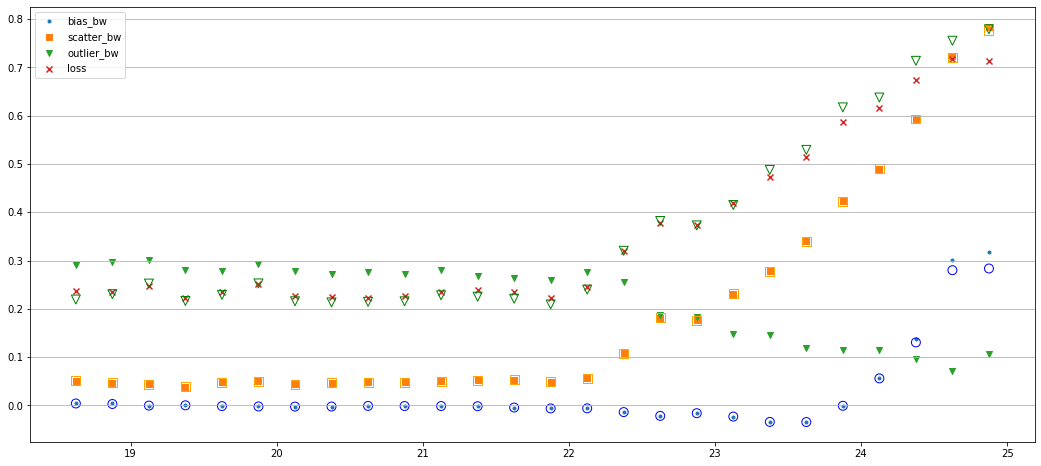

In [133]:
plt.scatter(x_list_mag,biweight_bias_mag,marker = ".",label = "bias_bw")
plt.scatter(x_list_mag,biweight_scatter_mag, marker = "s",label = "scatter_bw")
plt.scatter(x_list_mag,biweight_outlier_mag, marker = "v", label = "outlier_bw")
plt.scatter(x_list_mag,loss_mag, marker = "x", label = "loss")
plt.scatter(x_list_mag,conv_bias_mag,s=80, facecolors='none', edgecolors='b')
plt.scatter(x_list_mag,conv_scatter_mag,marker = "s",edgecolors = 'orange',facecolors = 'none',s = 80)
plt.scatter(x_list_mag,conv_outlier_mag,marker = "v",edgecolors = 'green',facecolors = 'none',s = 80)

plt.legend()
plt.rcParams["figure.figsize"] = (18,8)
plt.gca().yaxis.grid(True)
plt.show()